In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# The following notebook focuses on the second quantization representation for quantum systems

### We consider the Bose-Hubbard system with the following Hamiltonian for k lattice sites in 1 dimension

$$
\Large H = \sum_{k} \{ \tau_k(b^\dagger_{k} b_{k+1} + b_{k} b^\dagger_{k+1}) + U(n_{k}^2 - n_{k}) + \mu n_{k} \}
$$

where $b^\dagger$ , $b$ and $n$ are the creation, annahilation operators; as well as the number operator

For example let us consider only the kinetic Term. For 3 lattice sites that have periodic boundary conditions with $\tau=1$ for all terms for ease of computations, expanding this gives:

$$
b^\dagger_{1} b_{2} + b_{1} b^\dagger_{2} + b^\dagger_{2} b_{3} + b_{2} b^\dagger_{3} + b^\dagger_{3} b_{1} + b_{3} b^\dagger_{1}
$$

Hence when contracing the Hamiltonian with 2 states $|i>, |j>$ to get its matrix elements what we have to solve is

$$
<i| b^\dagger_{1} b_{2} + b_{1} b^\dagger_{2} + b^\dagger_{2} b_{3} + b_{2} b^\dagger_{3} + b^\dagger_{3} b_{1} + b_{3} b^\dagger_{1} |j>
$$

expanding this gives

$$
<i|b^\dagger_{1} b_{2}|j> + <i|b_{1} b^\dagger_{2}|j> + <i|b^\dagger_{2} b_{3}|j> + <i|b_{2} b^\dagger_{3}|j> + <i|b^\dagger_{3} b_{1}|j> + <i|b_{3} b^\dagger_{1}|j>
$$

Looping through all basis states |1>, |2>, ..., |i>,..., |j>, ...  will give us all i,j indexed pairs of the Hamiltonian Operator explicitly

It is clear here that in order to compute these terms we simply need functions regarding the creation and annahilation operators and how they transform states.

Let us take bosonic states for example and how they transform under these operators.

- Creation operator     : $b^\dagger_{k}|...,n_{k},...> = \sqrt{n_k + 1}|...,n_{k}+1,...>$
- Annahilation operator : $b_{k}|...,n_{k},...> = \sqrt{n_k}|...,n_{k}-1,...>$
- Number operator       : $n_{k}|...,n_{k},...> = n|...,n_{k},...>$

These definitions allow us to create states from any initial state. The next step is to create an ordered basis

*J M Zhang and R X Dong 2010 Eur. J. Phys. 31 591:  Exact diagonalization: the Bose–Hubbard model as an example*

gives the rules for lexicographical ordering of the basis. The total number of states is calculated through the Combinations with replacement formula:

$$
C^{R}_{(n,r)} = \dfrac{(n+r-1)!}{r!(n-1)!} 
$$

where n (number of objects) are the number of total sites and r (samples) are the number of bosons present in the Fock Space

This kind of truncation allows us to avoid calculating ALL possible states for k sites which for bosonic states is infinite due to the fact that multiple bosons can be stacked in the same state (in this ideal picture). Unlike fermions (all same spin) which can only occupy a single state at a time. Essentially truncating the space by default. We can however abuse the symmetry of particle conservation to truncate the bosonic space if we know the total number of bosons present in the system. We iterate through all possible Combinations with replacement and then order in lexicographical order. This is done very simply with the itertools from python.


The operators are very simply programmed as functions that take a state as input and give a state as output. We also need a "contract_states" function that takes the inner product of 2 states. These are very easily calculated in this representation because the basis is orthogonal and therefore inner products scale with the kroneker delta. So doing this operation is as simple as doing a direct comparison

Now is a good time to talk about the representation on the computer. A struct of type "bstate" is created that holds a pointer to an array of ints. The elements in this array are the direct numbers you find in the symbolic representation. For example the state $\eta|2,0,1,0>$ is directly represented as a struct that holds the information array: $$bstate =\{(2,0,1,0), 4, \eta\}$$
Where eta is the normalization constant front that simply multiplies the state. These are needed due to the application of the operators on the states.

We can see the bstate struct has a size in Bytes of 4+4+8 = 16 Bytes.

However the initial 4 Bytes are to the array pointer which itself can be very large so it is missleading to calculate memory usage with 16 Bytes only

### Note: Because i am very lazy, the states should not exceed an occupation number of 9. Therefore a state like 8,0,0 is pushing the limits of my lazy coding

Now after creating the ordered Basis full of bstate struct objects, getting the Hammiltonian matrix is as Trivial as looping through the basis and using the "contract_states" along with the "apply_creator/annahilator" functions to the basis bstates!

Because states are contracted after all operators are applied, we are guaranteed to get doubles as matrix elements.

In [2]:
%load_ext Cython

# Cell below for bosons

In [3]:
%%cython
cimport cython
from libc.stdlib cimport malloc, free
from libc.math cimport sqrt
from cython cimport sizeof
from itertools import combinations_with_replacement
from cython.parallel cimport prange


import numpy as np
cimport numpy as np

##
ctypedef struct bstate:
    int* state
    int size
    double norm_const

##    
cdef void free_bosons(bstate in_state) nogil:
    free(in_state.state)
    in_state.state = NULL

##
cdef print_state(bstate instate):
    for i in range(instate.size):
        print(instate.state[i], end=" ")
    print("\nstate sites =",instate.size,"\nnorm constant in front of state =",instate.norm_const)
    



##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef int factorial(int a, int start) nogil:
    if a == 0:
        return 1
    if start <= a:
        pass
    cdef int result, i
    result = 1
    for i in range(start-1, a):
        result = result*(i+1)
    return result
    

#recursive function for Combinations with replacements formula. Avoids int overflow in the division the old formula suffers of    
@cython.boundscheck(False)
@cython.wraparound(False)
cdef int bosonic_basis_size(int bosons, int sites) nogil:
    if bosons < 0 or sites < 0:
        raise ValueError("Negative sites or occupations")

    cdef int result = 1
    cdef int i

    for i in range(bosons):
        result *= (sites + i)

    for i in range(1, bosons + 1):
        result //= i

    return result

"""
cdef int bosonic_basis_size(int bosons, int sites) nogil:
    if (bosons<0) or (sites<0):
        raise ValueError("negative sites or occupations")
    cdef int result
    cdef int upper = sites + bosons -1
    cdef int lower = bosons
    cdef int const = upper - lower
    result = factorial(upper, const)
    result = result//factorial((sites-1), 1)

    return result
"""

##
cpdef int basis_size_python(int nrbosons, int nrsites):
    return bosonic_basis_size(nrbosons, nrsites)

##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef bstate* ordered_basis(int bosons, int sites):
    # Generate all possible combinations of site occupations with replacement
    combinations = list(combinations_with_replacement(range(sites), bosons))

    # Sort the combinations in lexicographic order
    combinations = sorted(combinations)
    cdef int length = len(combinations)

    # Create basis vectors from the sorted combinations
    cdef bstate* basis_vectors = <bstate*>malloc(length*sizeof(bstate))
    
    cdef int i
    for i in range(length):
        basis_vectors[i] = create_bosons("0" * sites, sites)  # Initialize with all zeros
        
        for site in combinations[i]:
            basis_vectors[i].state[site] += 1
            #basis_vectors[i].norm_const = sqrt(<double>basis_vectors[i].state[site]) needed ???? check theory books
    return basis_vectors



##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef bstate create_bosons(str state, int space_size) nogil:
    cdef int* state_array = <int*>malloc(space_size*sizeof(int))
    if state_array is NULL:
        raise MemoryError("Failed to allocate memory for state_array")
    
    for i in range(space_size):
        if state[i] < 0:
            raise ValueError("no negative occupation numbers for bosonic states")
        state_array[i] = <int>state[i]-48 #minus 48 because of ascii encoding from str to int. 0 is 48 in ascii. 1 is 49
    cdef bstate result
    result.state = state_array
    result.size = space_size
    result.norm_const = 1.
    return result


##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline bstate apply_creator(bstate in_state, int site) nogil:
    if site <= 0:
        raise ValueError("site number negative or 0")
    #index = site-1
    cdef int i
    cdef bstate cresult
    cresult.size = in_state.size
    cresult.state = <int*>malloc(in_state.size*sizeof(int))
    for i in range(in_state.size):
        cresult.state[i] = in_state.state[i]
    cresult.state[site-1] = in_state.state[site-1]+1
    cresult.norm_const = sqrt(cresult.state[site-1])*in_state.norm_const
    return cresult
##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline bstate apply_annahilator(bstate in_state, int site) nogil:
    if site <= 0:
        raise ValueError("site number negative or 0")
    #index = site-1
    cdef bstate aresult
    aresult.size = in_state.size
    aresult.state = <int*>malloc(in_state.size*sizeof(int))
    for i in range(in_state.size):
        aresult.state[i] = in_state.state[i]
    aresult.state[site-1] = in_state.state[site-1]-1

    if in_state.state[site-1] == 0:
        aresult.norm_const = 0.
    else:
        aresult.norm_const = sqrt(in_state.state[site-1])*in_state.norm_const
    return aresult

##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline bstate number_operator(bstate in_state, int site, int power) nogil:
    #index = site-1
    cdef bstate nresult
    nresult.size = in_state.size
    nresult.state = <int*>malloc(in_state.size*sizeof(int))
    for i in range(in_state.size):
        nresult.state[i] = in_state.state[i]
    nresult.state[site-1] = in_state.state[site-1]
    nresult.norm_const = <double>(nresult.state[site-1]**power)
    return nresult

##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline bint compare_states(bstate state1, bstate state2) nogil:
    if state1.size != state2.size:
        raise ValueError("states have different number of sites. direct comparison may be illogical")
    cdef int i
    for i in range(state1.size):
        if state1.state[i] != state2.state[i]:
            return 0
    return 1


##
cdef inline double contract_states(bstate state1, bstate state2) nogil:
    cdef double result
    if compare_states(state1, state2):
        result = state1.norm_const * state2.norm_const
        return result
    else:
        return 0.
    #free_bosons(state1)
    #free_bosons(state2)

    
    
##
@cython.boundscheck(False)
@cython.wraparound(False)
cdef inline void interacting_boson_gas(int bosons, int sites, double t, double U, double nu, bstate* basis, double[:,::1] nparr, int h_size) nogil:
    cdef bstate tmp_state1  #troubleshoot purposes
    cdef bstate tmp_state2
    cdef bstate tmp_state3
    cdef bstate tmp_state4
    cdef bstate tmp_state5
    cdef int i, j, k

    
    for i in range(h_size):
        for j in range(h_size):
            for k in range(sites):
                tmp_state1 = (apply_creator((apply_annahilator(basis[j], (k+1)%sites+1)), (k)%sites+1))
                tmp_state2 = (apply_annahilator((apply_creator(basis[j], (k+1)%sites+1)), (k)%sites+1))
                tmp_state3 = (number_operator(basis[j], k+1, 2))
                tmp_state4 = (number_operator(basis[j], k+1, 1))
                tmp_state5 = (number_operator(basis[j], k+1, 1))
                nparr[i][j] = \
                nparr[i][j] +\
                t*contract_states(basis[i], tmp_state1) +\
                t*contract_states(basis[i], tmp_state2) +\
                U*contract_states(basis[i], tmp_state3) +\
                U*contract_states(basis[i], tmp_state4) -\
                nu*contract_states(basis[i], tmp_state5)
                free(tmp_state1.state)
                free(tmp_state2.state)
                free(tmp_state3.state)
                free(tmp_state4.state)
                free(tmp_state5.state)
                


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double[:,::1] Bose_Hubbard(int bosons, int sites, double t, double U, double nu):
    cdef int h_size = bosonic_basis_size(bosons, sites)
    cdef bstate* basis = ordered_basis(bosons, sites)
    cdef double[:,::1] hamiltonian = np.zeros((h_size, h_size), dtype=np.float64)
    
    interacting_boson_gas(bosons, sites, t, U, nu, basis, hamiltonian, h_size)
    cdef size_t i
    for i in range(h_size):
        free_bosons(basis[i])
    free(basis)
    basis = NULL

    return hamiltonian
    
    
    
######################
######################
# little test unit below as proof of concept
######################
######################
cdef bstate* testbasis = ordered_basis(3, 3)
cdef int basis_size = bosonic_basis_size(3, 3)
print("\nbasis size is :", basis_size)
for i in range(basis_size):
    print_state(testbasis[i])


print(bosonic_basis_size(8,8))
#free loop
for i in range(basis_size):
    free_bosons(testbasis[i])
free(testbasis)
testbasis = NULL


basis size is : 10
3 0 0 
state sites = 3 
norm constant in front of state = 1.0
2 1 0 
state sites = 3 
norm constant in front of state = 1.0
2 0 1 
state sites = 3 
norm constant in front of state = 1.0
1 2 0 
state sites = 3 
norm constant in front of state = 1.0
1 1 1 
state sites = 3 
norm constant in front of state = 1.0
1 0 2 
state sites = 3 
norm constant in front of state = 1.0
0 3 0 
state sites = 3 
norm constant in front of state = 1.0
0 2 1 
state sites = 3 
norm constant in front of state = 1.0
0 1 2 
state sites = 3 
norm constant in front of state = 1.0
0 0 3 
state sites = 3 
norm constant in front of state = 1.0
6435


# ===> work in progress below

# Cell below for fermions

### Let's take the fermionic Hamiltonian with spin into consideration

$$
\Large H = \sum_{k} \{ \tau_k(f^\dagger_{k,\sigma} f_{k+1,\sigma} + f_{k,\sigma} f^\dagger_{k+1,\sigma}) + U(n_{k\uparrow} n_{k\downarrow})\}
$$

In [4]:
%%cython

cimport cython
from libc.stdlib cimport malloc, free
from cython cimport sizeof
#import numpy as np
#cimport numpy as np



ctypedef struct fstate:
    int state
    int size
    double norm_const
    
cdef inline char has_occupation(fstate in_state, int site) nogil:
    #remember the bitwise transposition below starts from the left hence the minus operation. it gives the output in improper index (starts from 1 not 0)
    return (in_state.state >> (in_state.size - site) & 1)



#Brian Kernighan's Algorithm
cdef int count_ones(fstate state, int in_index):
    cdef int count = 0
    cdef int mask = 1
    cdef int index = in_index - 1

    mask = mask << index  # Set the mask to the bit at the target index

    while mask > 0:
        if state.state & mask:
            count += 1
        mask >>= 1

    return count



#cdef fstate apply_foperator(fstate in_state, int site, int spin):
    

# Example usage
cdef fstate test


test.state = 18
test.size = 7
test.norm_const = 1.

cdef int site = 7

if has_occupation(test, site):
    print(f"Site {site} is occupied in state {test.state}")
else:
    print(f"Site {site} is not occupied in state {test.state}")

print(count_ones(test, site))

Site 7 is not occupied in state 18
2


In [5]:
#####################
#####################
# the main event. call the Cpython function Bose_Hubbard
# with nr bosons, nr sites, eta constant (static eta in this code)
# to create a numpy array that represents the full hamiltonian matrix
#####################
#####################
bosons = 6
sites = 7
t = 1
U = -0.095
nu = 0.08
ham = Bose_Hubbard(bosons, sites, t, U, nu)
space_size = basis_size_python(6,6)
print("\nsize of basis for 6 Bosons in 6 lattice Sites is:", space_size,"\ntotal nr of elements:", space_size**2)
print("\nthe hopping term t is set to:",t,"\nthe interaction Potential:",U,"\nthe chemical potential at:",nu)


size of basis for 6 Bosons in 6 lattice Sites is: 462 
total nr of elements: 213444

the hopping term t is set to: 1 
the interaction Potential: -0.095 
the chemical potential at: 0.08


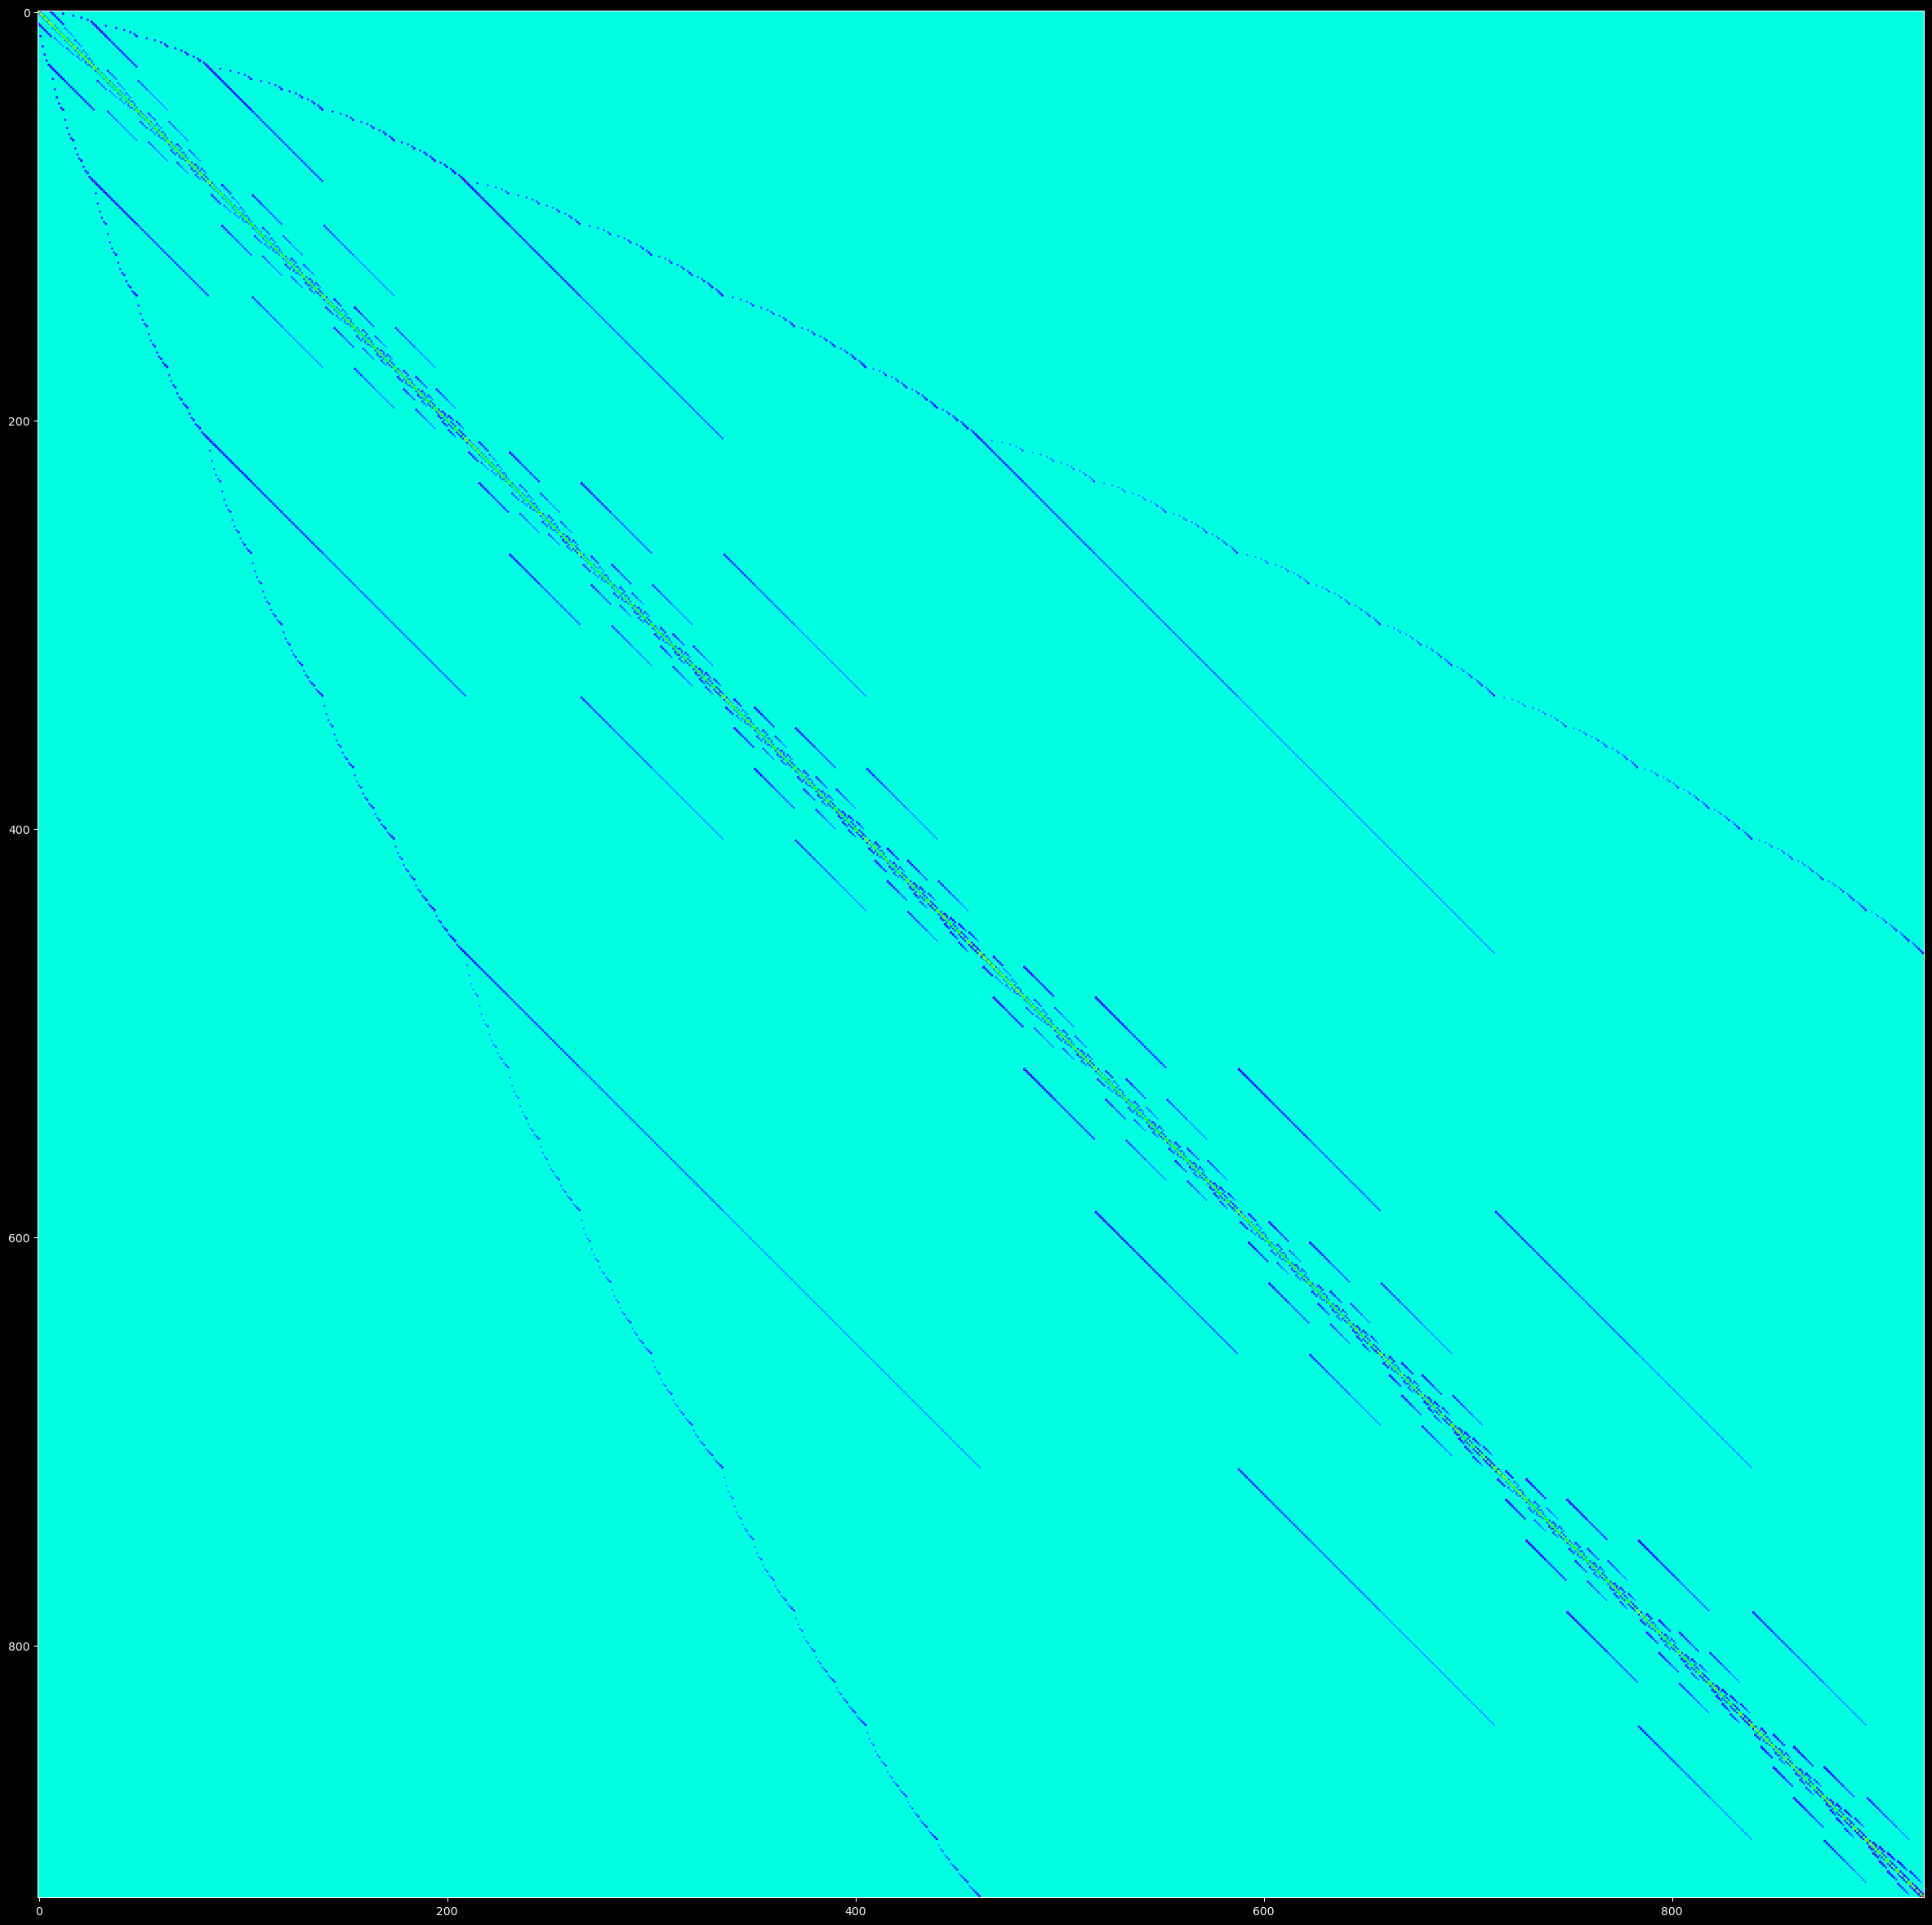

In [7]:
plt.figure(figsize = (30, 30))
plt.imshow(ham, cmap='gist_rainbow')

# Let us now test the spectrum of the Hamiltonian in various packages' routines

In [8]:
import scipy as sp

In [9]:

sparse_ham = sp.sparse.csr_matrix(ham)
k = 150

eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(sparse_ham, k=k, which='SA')


## Plotting the eigenvalues from smallest to largest

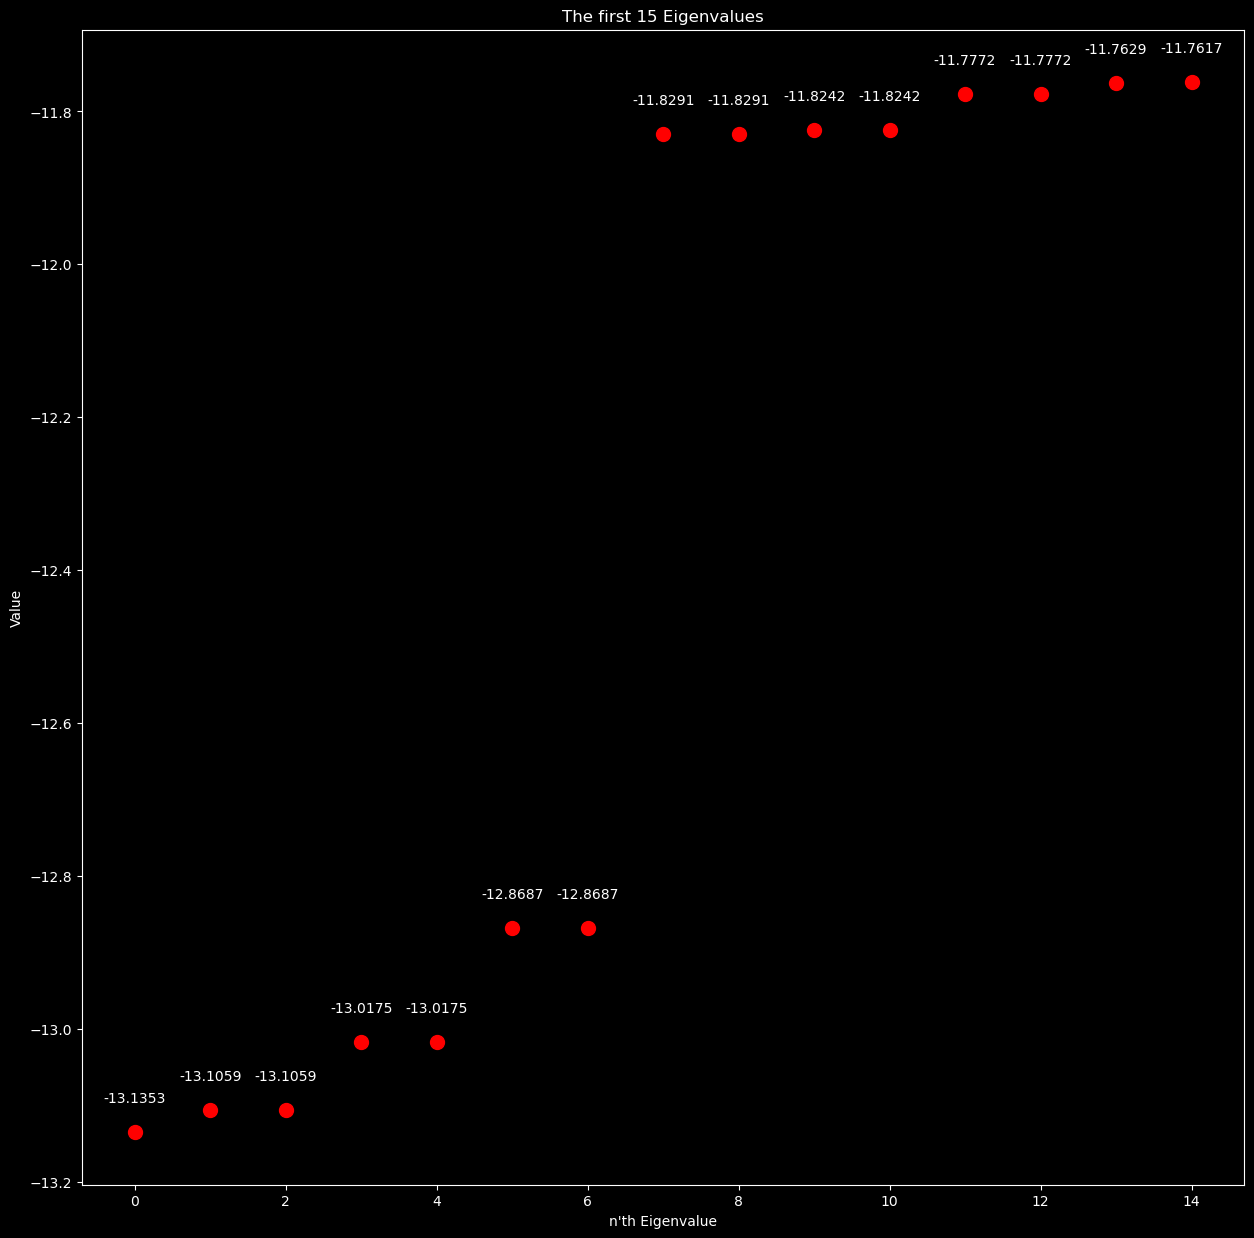

In [10]:
plt.figure(figsize = (15, 15))
plt.plot(eigenvalues[:15], 'o', markersize=10, color='red')
plt.xlabel("n'th Eigenvalue")
plt.ylabel("Value")
plt.title("The first 15 Eigenvalues")

for i in range(15):
    plt.text(i, eigenvalues[i]+0.035, "{:.4f}".format((eigenvalues[i])), ha='center', va='bottom')

plt.show()

## Plotting the eigenvectors (truncated to 150 terms). The first 8 are here

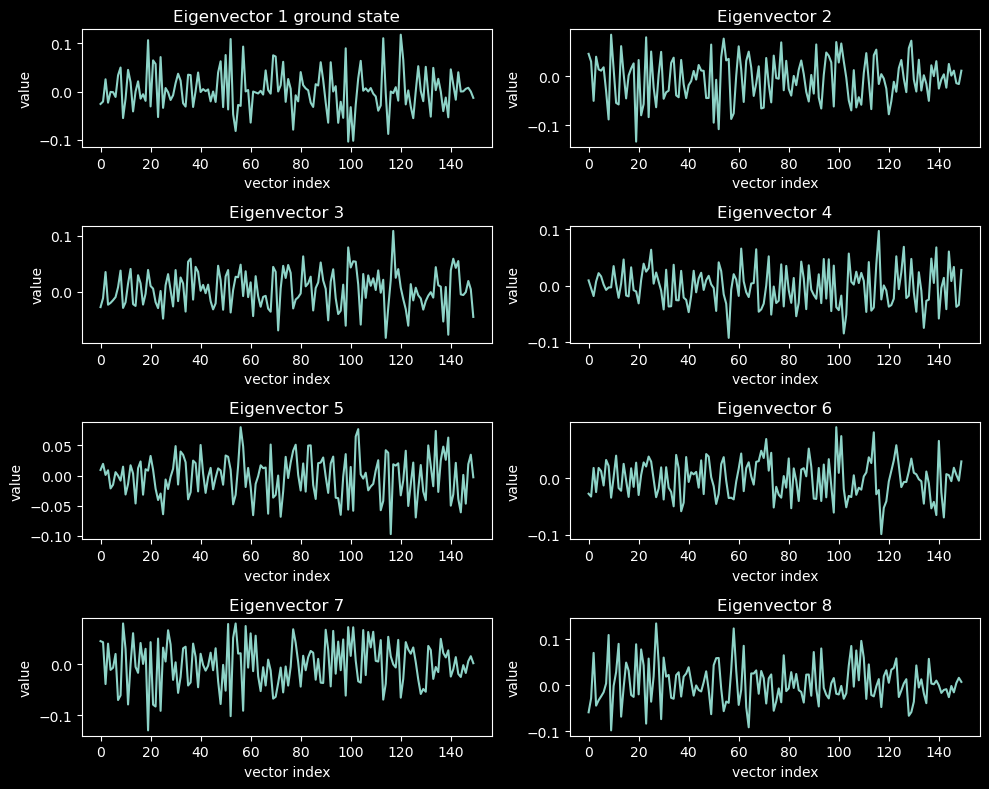

In [11]:
# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(10, 8))

# Set titles for each subplot
titles = ["Eigenvector 1 ground state", "Eigenvector 2", "Eigenvector 3", "Eigenvector 4", "Eigenvector 5", "Eigenvector 6", "Eigenvector 7", "Eigenvector 8"]

for i, ax in enumerate(axs.flat):
    ax.plot(eigenvectors[i])
    ax.set_title(titles[i])
    ax.set_xlabel("vector index")
    ax.set_ylabel("value")

# Automatically adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()

# Let's GUI this

In [12]:
import tkinter as tk
import time
from tkinter import scrolledtext
import tkinter.filedialog as filedialog

In [6]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

plt.style.use('dark_background')

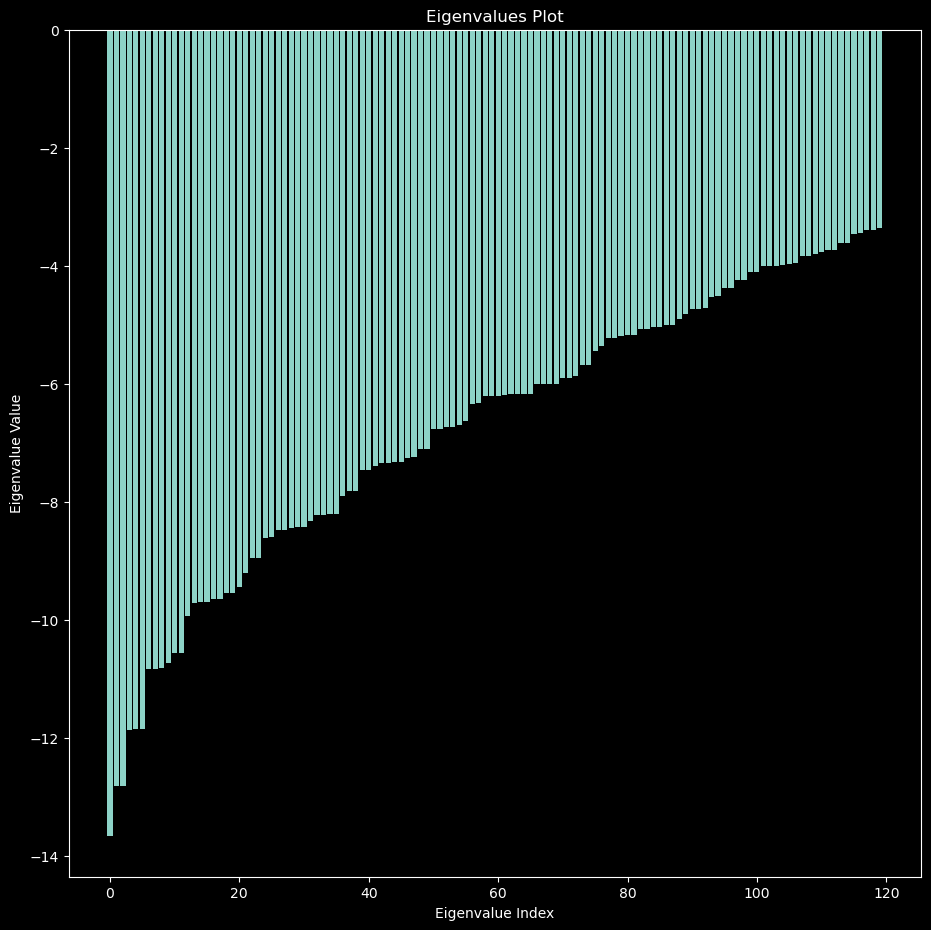

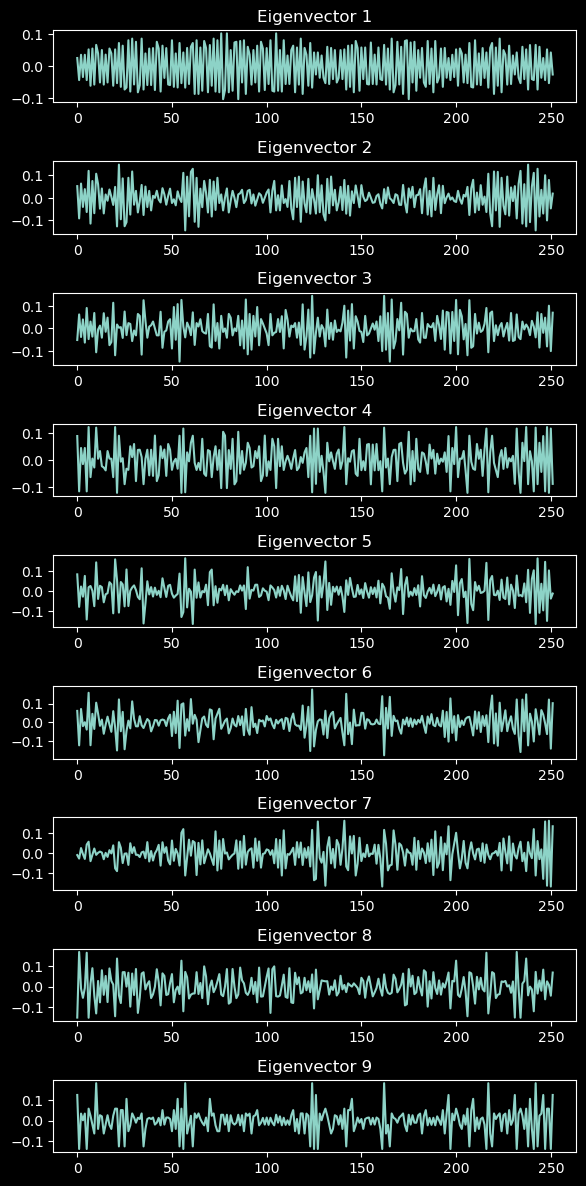

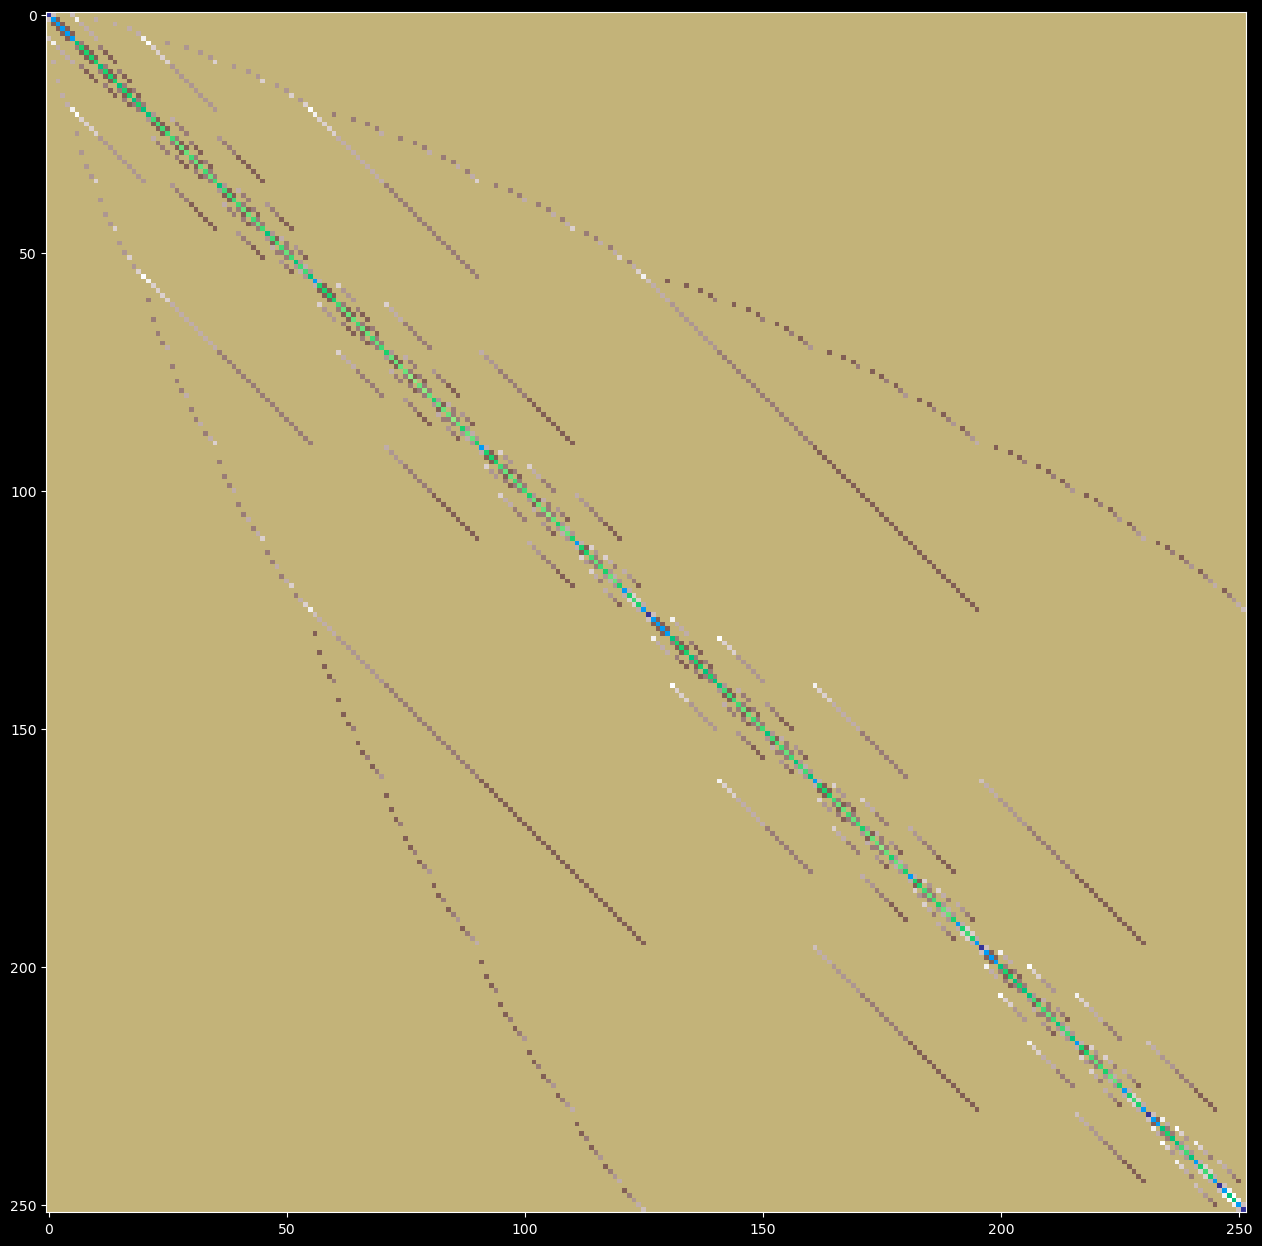

In [14]:
# Create functions to set global variables and validate user input
def apply_all():
    global particles, sites, interaction_potential, chemical_potential, t
    new_particles = particles_entry.get()
    new_sites = sites_entry.get()
    new_interaction_potential = interaction_potential_entry.get()
    new_chemical_potential = chemical_potential_entry.get()
    new_t = t_entry.get()
    
    try:
        if new_particles:
            particles = int(new_particles)
        if new_sites:
            sites = int(new_sites)
        if new_interaction_potential:
            interaction_potential = float(new_interaction_potential)
        if new_chemical_potential:
            chemical_potential = float(new_chemical_potential)
        if new_t:
            t = float(new_t)

        # Update the labels
        particles_label.config(text=f"Particles: {particles}")
        sites_label.config(text=f"Sites: {sites}")
        interaction_potential_label.config(text=f"Interaction Potential: {interaction_potential}")
        chemical_potential_label.config(text=f"Chemical Potential: {chemical_potential}")
        t_label.config(text=f"Hopping Term: {t}")

        # Update the "Current Numbers" label
        update_current_numbers_label()
        stuff = "\nNumbers were successfully updated!"
        update_information(stuff)

    except ValueError:
        message = "\nError!: Invalid input detected!\nPlease check if all the inputs for the Constants are numbers!"
        update_information(message)
        raise ValueError(message)
        

        
        
def set_truncation():
    global truncate
    new_truncate = truncate_entry.get()
    try:
        truncate = int(new_truncate)
        truncate_label.config(text=f"first k eigenvalues: {truncate}")
        update_information(f"\nCalculating first k = {truncate} eigenpairs")
    except ValueError:
        raise ValueError('Input should be a valid number')
        tk.messagebox.showinfo("ERROR", "Input should be a valid number.")

# Function to update the "Current Numbers" label
def update_current_numbers_label():
    current_numbers_label.config(text=f"Current Numbers:\n Particles: {particles}\n Sites: {sites} \n Hopping Term: {t} \n Interaction Potential: {interaction_potential}\n Chemical Potential: {chemical_potential}")

    
def update_eigval_plot_size(event):
    eig_val_canvas.get_tk_widget().config(width=event.width, height=event.height)
    

    
#main event
def get_hamiltonian():
    global hamiltonian
    global has_run
    global basis_size
    global total_elements
    #current_time = time.strftime('%Y-%m-%d %H:%M:%S')
    #info = f"\n[{current_time}]\nStarting Matrix calculation...\n.\n.\n.\n"
    #text_area.insert(tk.INSERT, info)
    start_time = time.time()
    hamiltonian = Bose_Hubbard(particles, sites, t, interaction_potential, chemical_potential)
    end_time = time.time()
    elapsed_time = end_time - start_time
    has_run = True
    basis_size = hamiltonian.shape[0]
    total_elements = basis_size**2
    if elapsed_time != 0:
        fetch_rate = int(total_elements/elapsed_time)
    else:
        fetch_rate = "~~time interval too short~~"
    message = f"\nElements Fetched in:\n{elapsed_time:.6f} seconds.\nFetch rate: {fetch_rate} elements/sec\nTotal nr of elements: {total_elements}\nBasis Size: {basis_size_python(particles, sites)}"
    #info = f"Successfully Updated Hamiltonian Matrix in {elapsed_time:.6f} seconds"
    #tk.messagebox.showinfo("Calculation Complete", message)
    update_information(message)

def diagonalize():
    global hamiltonian
    global eigenvalues
    global eigenvectors
    global truncate
    global has_diagonalized
    global format_t
    global particles
    global sites
    
    if has_run == False:
        update_information("Fatal Error!: No Hamiltonian present in global memory. Ending function...")
        return
    elif truncate == 0:
        update_information("Error!: The k first Eigenpairs constant is set to 0. It has to be between 1 and the basis size\nEnding function...")
        return
    elif truncate >= basis_size_python(particles, sites):
        msg = f"k value of: {truncate} is too large. It has to be smaller than the basis size of {basis_size_python(particles, sites)}"
        update_information(msg)
        return

    if format_t == "Sparse SciPy CSR format":
        sparse_ham = sp.sparse.csr_matrix(hamiltonian)
        truncate = truncate
        start_time = time.time()
        eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(sparse_ham, k=truncate, which='SA')
        end_time = time.time()
        elapsed_time = end_time - start_time
        has_diagonalized = True
        message = f"Eigenpairs Calculated in\n {elapsed_time:.6f} \nseconds."
        update_information(message)
        has_diagonalized = True
    else:
        start_time = time.time()
        eigenvalues, eigenvectors = np.linalg.eig(hamiltonian)
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:,idx]
        end_time = time.time()
        elapsed_time = end_time - start_time
        has_diagonalized = True
        message = f"Eigenpairs Calculated in\n {elapsed_time:.6f} \nseconds."
        update_information(message)
        has_diagonalized = True
        
    
    
    


def display_hamiltonian():
    global hamiltonian
    if has_run == False:
        message = "No Hamiltonian present in global memory. Please Calculate the Hamiltonian Matrix first!\nFunction Terminating..."
        update_information(message)
        return
    ax.clear()
    ax.imshow(hamiltonian, cmap=color_scheme)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    canvas.draw()
    canvas.get_tk_widget().place(x=200, y=0)
    
# Function to display eigenvalues
# Function to display eigenvalues
def display_eigenvalues():
    global eigenvalues, has_diagonalized
    
    if not has_diagonalized:
        message = "No Hamiltonian present in global memory. Please Calculate the Hamiltonian Matrix first!\nFunction Terminating..."
        update_information(message)
        return
    
    def display_eigenvalues_list():
        if eigenvalues is not None:
            eig_val_area.delete(1.0, tk.END)  # Clear the text area
            eig_val_area.insert(tk.END, "Output:\nEigenvalues List:\n")
            for i, eigenvalue in enumerate(eigenvalues):
                eig_val_area.insert(tk.END, f"Eigenvalue {i}: {eigenvalue}\n")
        else:
            eig_val_area.delete(1.0, tk.END)  # Clear the text area
            eig_val_area.insert(tk.END, "No eigenvalues available. Please run diagonalization.")

    def export_eigenvalues():
        global eigenvalues
    
        if eigenvalues is None:
            message = "No eigenvalues to export. Please calculate eigenvalues first."
            update_information(message)
            return
    
        # Open a file dialog to choose the save directory and file name
        file_path = filedialog.asksaveasfilename(defaultextension=".txt", filetypes=[("Text files", "*.txt")])
    
        if file_path:
            with open(file_path, "w") as file:
                for i, eigenvalue in enumerate(eigenvalues):
                    file.write(f"{eigenvalue}\n")
        
            message = f"Eigenvalues have been exported to {file_path}"
            update_information(message)
    # Create a new window for plotting eigenvalues
    eigenvalues_window = tk.Toplevel(root)
    eigenvalues_window.title("Eigenvalues Plot")
    eigenvalues_window.geometry("1400x1152")
    
    # Create a new figure for the eigenvalues plot
    eig_val_fig = plt.figure(figsize=(11,11))
    plt.bar(range(len(eigenvalues)), eigenvalues)
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue Value")
    plt.title("Eigenvalues Plot")
    
    # Create a separate canvas for the new figure
    eig_val_canvas = FigureCanvasTkAgg(eig_val_fig, master=eigenvalues_window)
    eig_val_canvas.get_tk_widget().pack(anchor='nw')
    #eig_val_canvas.get_tk_widget().bind("<Configure>", update_plot_size)
    eig_val_canvas.draw()
    eig_val_area_frame = tk.Frame(eigenvalues_window)
    eig_val_area_frame.place(x=1100, y=0, width=300, height=1100)
    eig_val_area = scrolledtext.ScrolledText(eig_val_area_frame, wrap=tk.WORD)
    eig_val_area.pack(expand=1, fill='both')
    default_text = "Output:\n~~~~~~~~~~\n"
    eig_val_area.insert(tk.INSERT, default_text)
    
    display_list_button = tk.Button(eigenvalues_window, text="Display as List", command=display_eigenvalues_list, width=50)
    display_list_button.pack(anchor='nw')

    export_button = tk.Button(eigenvalues_window, text="Export", command=export_eigenvalues, width=50)
    export_button.pack(anchor='nw')


    
##
# Function to display eigenvectors
def display_eigenvectors():
    global eigenvectors, has_diagonalized
    
    if not has_diagonalized:
        message = "No Hamiltonian present in global memory. Please Calculate the Hamiltonian Matrix first!\nFunction Terminating..."
        update_information(message)
        return
    
    def export_eigenvectors():
        global eigenvectors

        if eigenvectors is None:
            message = "No eigenvectors to export. Please calculate eigenvectors first."
            update_information(message)
            return

        # Open a file dialog to choose the save directory and file name
        file_path = filedialog.asksaveasfilename(defaultextension=".txt", filetypes=[("Text files", "*.txt")])

        if file_path:
            with open(file_path, "w") as file:
                for i in range(eigenvectors.shape[1]):
                    file.write(f"Eigenvector {i + 1}:\n")
                    for j in range(eigenvectors.shape[0]):
                        file.write(f"{eigenvectors[j, i]}\n")
                    file.write("\n")

            message = f"Eigenvectors have been exported to {file_path}"
            update_information(message)
    
    # Create a new window for plotting eigenvectors
    eigenvectors_window = tk.Toplevel(root)
    eigenvectors_window.title("Eigenvectors Plot")

    # Create a subplot for each eigenvector
    num_eigenvectors = min(9, eigenvectors.shape[1])  # Display up to 9 eigenvectors
    fig, axs = plt.subplots(num_eigenvectors, 1, figsize=(6, 12))
    
    for i in range(num_eigenvectors):
        axs[i].plot(eigenvectors[:, i])
        axs[i].set_title(f"Eigenvector {i + 1}")
    
    plt.tight_layout()

    # Embed the Matplotlib plot in the Tkinter window
    eig_vec_canvas = FigureCanvasTkAgg(plt.gcf(), master=eigenvectors_window)
    eig_vec_canvas.get_tk_widget().pack()
    eig_vec_canvas.draw()
    
    export_button = tk.Button(eigenvectors_window, text="Export", command=export_eigenvectors, width=50)
    export_button.pack(anchor='nw')



def update_information(message):
    current_time = time.strftime('%Y-%m-%d %H:%M:%S')
    full_message = f'[{current_time}] Out:\n{message}\n~~~~~~~~~~\n'
    text_area.insert(tk.INSERT, full_message)
    text_area.see(tk.END)  # Scroll to the end
    
def update_color_scheme(*args):
    global color_scheme
    color_scheme = color_var.get()
    display_hamiltonian()
    
    
def update_model(*args):
    global model
    model = model_var.get()
    message = f"\nCurrent Model was set to: {model}"
    update_information(message)
    #fx 

def update_format(*args):
    global format_t
    format_t = format_t_var.get()
    message = f"\nExport format changed to: {format_t}"
    update_information(message)
    #fx 
    
############
############
# Initialize global variables
############
############
model = 'Bose-Hubbard'
models = [
    'Bose-Hubbard', 'Fermi-Hubbard', 't-J Model', 'External Field Ising Model', '2Q Jordan-Wigner Ising', 'Anderson Model',
    'Heisenberg Model', 'XXY model'
]
particles = 3
sites = 3
interaction_potential = -0.18  # Default value as float
chemical_potential = 0.04     # Default value as float
t = 1.0                      # Default value as float
hamiltonian = None #initialize empty global
eigenvalues = None #empty global
eigenvectors = None #empty global
truncate = 9
has_run = False
has_diagonalized = False
basis_size = 0
total_elements = 0
color_scheme = 'terrain'
color_schemes = [
    "gist_rainbow", "coolwarm", "viridis", "plasma", "inferno", "magma",
    "twilight", "YlOrBr", "RdGy", "copper",
    "nipy_spectral", "cividis", "ocean", "terrain", "gnuplot", "jet",
    "Set1", "Set2", "Set3", "Pastel1", "Pastel2",
]
format_options = [
    "Dense Numpy format",
    "Sparse SciPy CSR format"
]
format_t = "Sparse SciPy CSR format"


###########
###########
# Create the main window
###########
###########
root = tk.Tk()
root.title("Quantum Sail ver1.0")
root.geometry("1880x1250")


############
############
# Create the central plot from TkAgg and matplotlib's backend
############
############
fig, ax = plt.subplots(figsize=(12,12))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack()
canvas.get_tk_widget().place(x=200, y=0)




############
############
# Area on the Right for Output Prompt. Uses tkinters Scrolledtext module
############
############
text_area_frame = tk.Frame(root)
text_area_frame.place(x=1401, y=0, width=470, height=1000)
text_area = scrolledtext.ScrolledText(text_area_frame, wrap=tk.WORD)
text_area.pack(expand=1, fill='both', anchor='nw')
default_text = "Welcome! \nQuantum Many-Body Theory Calculator\nCurrent Ver: 1.0\nAuthor: Enea Çobo\nCurrent \
release date: 25 October 2023\nThe Following Software comes with Backend functionality from Matplotlib's graphing Capabilities \
as well as Tkinter for its GUI. It is currently capable of diagonalizing with scipy's modules, plotting Eigenvalues \
or Eigenvectors and explicitly importing or exporting Hamiltonian Operators in matrix format to undergo analysis. \
The current functioning models are the Bose and Fermi Hubbard models. Other quantum systems will be added in later \
patches. These will also include Classical analysis like Spin lattices through Monte Carlo methods such as Metropolis-Hastings \
or TDGL equations. Enjoy !\n.    .    .    .    .    .    .    .    .    .    .    .\n.    .    .    .    .    .    .    .    .    .    .    .\n~~~~~~~~~~\n"
text_area.insert(tk.INSERT, default_text)



############
############
# Chose the Model you want to compute
############
############

# Create a variable to store the selected model scheme
model_var = tk.StringVar()
model_var.set(model)  # Set the default model scheme which is model = 'Bose-Hubbard'

# Create the OptionMenu widget
model_option_menu = tk.OptionMenu(root, model_var, *models)
model_option_menu.pack(anchor='nw')

# Configure the width of the OptionMenu button
model_option_menu.config(width=25)  # Adjust the width as needed

# Attach a trace to update the model
model_var.trace("w", update_model)



############
############
# Create entry fields for bosons, sites, interaction potential, chemical potential, and hopping term
############
############
particles_label = tk.Label(root, text=f"Particles: {particles}")
particles_label.pack(anchor='nw')
particles_entry = tk.Entry(root)
particles_entry.pack(anchor='nw')

sites_label = tk.Label(root, text=f"Sites: {sites}")
sites_label.pack(anchor='nw')
sites_entry = tk.Entry(root)
sites_entry.pack(anchor='nw')

t_label = tk.Label(root, text=f"Hopping Term: {t}")
t_label.pack(anchor='nw')
t_entry = tk.Entry(root)
t_entry.pack(anchor='nw')

interaction_potential_label = tk.Label(root, text=f"Interaction Potential: {interaction_potential}")
interaction_potential_label.pack(anchor='nw')
interaction_potential_entry = tk.Entry(root)
interaction_potential_entry.pack(anchor='nw')

chemical_potential_label = tk.Label(root, text=f"Chemical Potential: {chemical_potential}")
chemical_potential_label.pack(anchor='nw')
chemical_potential_entry = tk.Entry(root)
chemical_potential_entry.pack(anchor='nw')






############
############
# Create "Apply" buttons for setting variables and get+plot hamiltonian
############
############
apply_all_button = tk.Button(root, text="Apply All Numbers", command=apply_all, width=20)
apply_all_button.pack(anchor='nw')
#
get_hamiltonian_button = tk.Button(root, text="Get Hamiltonian", command=get_hamiltonian, width=20)
get_hamiltonian_button.pack(anchor='nw')
#
display_button = tk.Button(root, text="Display Hamiltonian", command=display_hamiltonian, width=20)
display_button.pack(anchor='nw')
# Create a label to display the current numbers
state_text = f"Current Numbers:\n Particles: {particles}\n Sites: {sites} \n Hopping Term: {t} \n Interaction Potential: {interaction_potential}\n Chemical Potential: {chemical_potential}"
current_numbers_label = tk.Label(root, text=state_text)
current_numbers_label.pack(anchor='nw')


############
############
#Eigenpair commands and buttons
############
############

truncate_label = tk.Label(root, text=f"first k eigenvalues:")
truncate_label.pack(anchor='nw')
truncate_entry = tk.Entry(root)
truncate_entry.pack(anchor='nw')
#
apply_truncation_button = tk.Button(root, text="Apply k value", command=set_truncation, width=20)
apply_truncation_button.pack(anchor='nw')

diagonalize_button = tk.Button(root, text="diagonalization", command=diagonalize, width=20)
diagonalize_button.pack(anchor='nw')
#
display_eigenvalues_button = tk.Button(root, text="display eigenvalues", command=display_eigenvalues, width=20)
display_eigenvalues_button.pack(anchor='nw')
#
display_eigenvectors_button = tk.Button(root, text="display eigenvectors", command=display_eigenvectors, width=20)
display_eigenvectors_button.pack(anchor='nw')
#



###########
###########
#Buttons for plot manipulations and external options
###########
###########

# Create a variable to store the selected color scheme
color_var = tk.StringVar()
color_var.set(color_scheme)
color_option_menu = tk.OptionMenu(root, color_var, *color_schemes)
color_option_menu.pack()
color_option_menu.place(x=198, y=1200) 
color_option_menu.config(width=25)
color_var.trace("w", update_color_scheme)

#~~~

format_t_var = tk.StringVar()
format_t_var.set(format_t)
format_t_option_menu = tk.OptionMenu(root, format_t_var, *format_options)
format_t_option_menu.pack()
format_t_option_menu.place(x=390, y=1200)
format_t_option_menu.config(width=25)
format_t_var.trace("w", update_format)


#
##
###
####
# Start the GUI loop
####
###
##
#
root.mainloop()

